In [1]:
%pylab inline
import pickle
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_18r=pd.read_pickle('df_18r.pkl')

In [20]:
def SignificanceScan(df):
    sig_array=[]    
    sign_array=[]
    max_score=np.max(df['Score'])
    min_score=0
    score_list=np.linspace(min_score,max_score,50)
    for i in score_list:
        df_cut=df.query('Score>@i')['InvMass']
        counts,bins=np.histogram(df_cut,bins=50,range=[2.96,3.04]);
        bin_centers = 0.5*(bins[1:]+bins[:-1])
        sidemap=(bin_centers<2.9923-3*0.0029) + (bin_centers>2.9923+3*0.0029)
        massmap=logical_not(sidemap)
        bins_side = bin_centers[sidemap]
        counts_side= counts[sidemap]
        h=polyfit(bins_side,counts_side,2)
        y=polyval(h,bins_side)
        counts_mass= sum(counts[massmap])
        bkg=sum(polyval(h,bin_centers[massmap]))
        sig=counts_mass-bkg
        significance=sig/sqrt(sig+bkg+1e-10)
        sig_array.append(sig)
        sign_array.append(significance)
    plot(score_list,sign_array,'b')
    print('Best Score: ',float(score_list[np.where(sign_array==np.max(sign_array))]))
    print('Significance: ',np.max(sign_array))
    sig_array=np.asarray(sig_array)
    print('Raw yield: ', float(sig_array[np.where(sign_array==np.max(sign_array))]))


Best Score:  6.233509452975526
Significance:  9.221705367165697
Raw yield:  115.9150390625


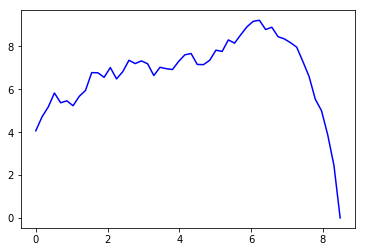

In [21]:
SignificanceScan(df_18r)

## Example

In [59]:
df_18r=df_18r.astype('float')
df_cut=df_18r.query('Score>4')['InvMass']
counts,bins=np.histogram(df_cut,bins=50,range=[2.96,3.04]);
bin_centers = 0.5*(bins[1:]+bins[:-1])
sidemap=(bin_centers<2.9923-3*0.0029) + (bin_centers>2.9923+3*0.0029)
massmap=logical_not(sidemap)
bins_side = bin_centers[sidemap]
counts_side= counts[sidemap]
h=polyfit(bins_side,counts_side,2)
y=polyval(h,bins_side)
counts_mass= sum(counts[massmap])
bkg=sum(polyval(h,bin_centers[massmap]))
sig=counts_mass-bkg
significance=sig/sqrt(sig+bkg+1e-10)

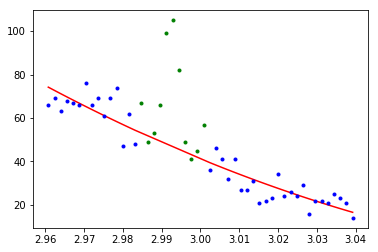

In [60]:
plt.plot(bins_side,y,'r')
plt.plot(bins_side,counts_side,'b.')
plt.plot(bin_centers[massmap],counts[massmap],'g.')